<a href="https://colab.research.google.com/github/AdithiVS/Financial-Sentiment-Analysis-using-LSTM/blob/main/DL_festive_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import logging
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
import pickle

In [5]:
# Function to load data
def load_data(file_path):
    if not os.path.exists(file_path):
        logging.error(f"File {file_path} does not exist.")
        raise FileNotFoundError(f"The file {file_path} was not found.")
    data = pd.read_csv(file_path)
    logging.info(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
    return data

# Preprocess text data
def clean_text(text):
    """
    Function to clean and preprocess text by removing special characters, converting to lowercase,
    and stripping whitespaces.
    """
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Trim whitespaces
    return text

In [6]:
# Tokenize and pad sequences
def preprocess_text_data(data, maxlen=100):
    """
    Function to preprocess text by cleaning, tokenizing, and padding sequences.
    """
    # Clean the text data
    data['cleaned_text'] = data['Sentence'].map(clean_text)

    # Tokenize the cleaned text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['cleaned_text'])
    X = tokenizer.texts_to_sequences(data['cleaned_text'])
    X = pad_sequences(X, maxlen=maxlen)
    logging.info(f"Text data tokenized and padded to a shape of {X.shape}.")

    return X, tokenizer

In [7]:
# Function to encode sentiment labels
def encode_sentiments(data):
    le = LabelEncoder()
    data['encoded_sentiment'] = le.fit_transform(data['Sentiment'])
    logging.info(f"Sentiment labels encoded. Classes: {le.classes_}")
    return data, le

In [8]:
# Build the LSTM model
def build_lstm_model(input_shape, tokenizer):
    """
    Function to build and compile the LSTM model.
    """
    input_layer = Input(shape=input_shape, dtype='int32')
    embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_layer)
    lstm_1 = LSTM(128, return_sequences=True)(embedding)
    dropout_1 = Dropout(0.5)(lstm_1)
    lstm_2 = LSTM(64)(dropout_1)
    output_layer = Dense(3, activation='softmax')(lstm_2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    logging.info("LSTM model built and compiled successfully.")
    return model

In [9]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred_classes)
    logging.info(f"Accuracy: {accuracy:.2f}")

    # Generate classification report
    logging.info("Classification Report:")
    print(classification_report(y_test, y_pred_classes))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [10]:
# Function to save model and tokenizer
def save_model_and_tokenizer(model, tokenizer, model_filename='model.h5', tokenizer_filename='tokenizer.pkl'):
    model.save(model_filename)
    logging.info(f"Model saved as {model_filename}.")

    with open(tokenizer_filename, 'wb') as handle:
        pickle.dump(tokenizer, handle)
    logging.info(f"Tokenizer saved as {tokenizer_filename}.")

In [11]:
# Main execution flow
def main(file_path='data.csv'):
    # Load and preprocess data
    data = load_data(file_path)
    X, tokenizer = preprocess_text_data(data)
    data, le = encode_sentiments(data)

    # Train-test split
    y = data['encoded_sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logging.info(f"Data split into training and test sets with {X_train.shape[0]} train samples and {X_test.shape[0]} test samples.")

    # Build and train model
    model = build_lstm_model(input_shape=(X.shape[1],), tokenizer=tokenizer)
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

    # Save model and tokenizer
    save_model_and_tokenizer(model, tokenizer)

    # Evaluate the model
    evaluate_model(model, X_test, y_test)

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 291ms/step - accuracy: 0.5508 - loss: 0.9587 - val_accuracy: 0.6852 - val_loss: 0.7472
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 83s 300ms/step - accuracy: 0.7568 - loss: 0.5936 - val_accuracy: 0.7134 - val_loss: 0.6940
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.8651 - loss: 0.3247 - val_accuracy: 0.7074 - val_loss: 0.8500
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 79s 284ms/step - accuracy: 0.8954 - loss: 0.2225 - val_accuracy: 0.6980 - val_loss: 0.9528
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 284ms/step - accuracy: 0.8962 - loss: 0.1869 - val_accuracy: 0.6997 - val_loss: 0.9930


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
              precision    recall  f1-score   support

           0       0.35      0.22      0.27       175
           1       0.73      0.82      0.77       622
           2       0.75      0.73      0.74       372

    accuracy                           0.70      1169
   macro avg       0.61      0.59      0.59      1169
weighted avg       0.68      0.70      0.69      1169



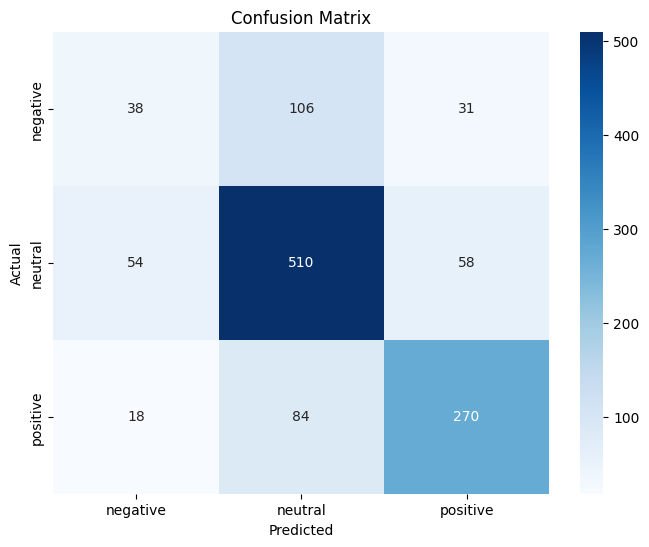

In [12]:
# Example of testing the model with new input text
def predict_sentiment(text, model, tokenizer, le):
    cleaned_text = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=100)
    prediction = model.predict(padded)
    predicted_label = np.argmax(prediction)
    sentiment = le.inverse_transform([predicted_label])[0]
    logging.info(f"Predicted Sentiment: {sentiment}")
    return sentiment

if __name__ == "__main__":
    main()
